# Shor

In [211]:
import matplotlib.pyplot as plt
import numpy as np
from qiskit import QuantumCircuit, transpile
from qiskit_aer import AerSimulator as Aer
from qiskit.visualization import plot_histogram
from math import gcd
from numpy.random import randint
import pandas as pd
from fractions import Fraction
print("Imports Successful")

Imports Successful


In [212]:
N = 35
a = 3

def c_amod15(a, power):
    """Controlled multiplication by a mod 15"""
    if a not in [2,4,7,8,11,13]:
        raise ValueError("'a' must be 2,4,7,8,11 or 13")
    U = QuantumCircuit(4)
    for _iteration in range(power):
        if a in [2,13]:
            U.swap(2,3)
            U.swap(1,2)
            U.swap(0,1)
        if a in [7,8]:
            U.swap(0,1)
            U.swap(1,2)
            U.swap(2,3)
        if a in [4, 11]:
            U.swap(1,3)
            U.swap(0,2)
        if a in [7,11,13]:
            for q in range(4):
                U.x(q)
    U = U.to_gate()
    U.name = f"{a}^{power} mod 15"
    c_U = U.control()
    return c_U

In [213]:
# Specify variables
qubits_count = 5  # number of counting qubits
a = 7

In [214]:
def qft_dagger(n):
    """n-qubit QFTdagger the first n qubits in circ"""
    qc = QuantumCircuit(n)
    # Don't forget the Swaps!
    for qubit in range(n//2):
        qc.swap(qubit, n-qubit-1)
    for j in range(n):
        for m in range(j):
            qc.cp(-np.pi/float(2**(j-m)), m, j)
        qc.h(j)
    qc.name = "QFT†"
    return qc

In [215]:
# Create QuantumCircuit with N_COUNT counting qubits
# plus 4 qubits for U to act on
qc = QuantumCircuit(qubits_count + 4, qubits_count)

# Initialize counting qubits
# in state |+>
for q in range(qubits_count):
    qc.h(q)

# And auxiliary register in state |1>
qc.x(qubits_count)

# Do controlled-U operations
for q in range(qubits_count):
    qc.append(c_amod15(a, 2**q),
             [q] + [i+qubits_count for i in range(4)])

# Do inverse-QFT
qc.append(qft_dagger(qubits_count), range(qubits_count))

# Measure circuit
qc.measure(range(qubits_count), range(qubits_count))
qc.draw(fold=-1)  # -1 means 'do not fold'

┌───┐                                                                            ┌───────┐┌─┐            
q_0: ┤ H ├───────■────────────────────────────────────────────────────────────────────┤0      ├┤M├────────────
     ├───┤       │                                                                    │       │└╥┘┌─┐         
q_1: ┤ H ├───────┼──────────────■─────────────────────────────────────────────────────┤1      ├─╫─┤M├─────────
     ├───┤       │              │                                                     │       │ ║ └╥┘┌─┐      
q_2: ┤ H ├───────┼──────────────┼──────────────■──────────────────────────────────────┤2 QFT† ├─╫──╫─┤M├──────
     ├───┤       │              │              │                                      │       │ ║  ║ └╥┘┌─┐   
q_3: ┤ H ├───────┼──────────────┼──────────────┼──────────────■───────────────────────┤3      ├─╫──╫──╫─┤M├───
     ├───┤       │              │              │              │                       │       │ ║  ║  ║ └╥┘┌─┐
q_4: ┤ H ├───────┼──────────────┼──────────────┼──────────────┼──────────────■────────┤4      ├─╫──╫──╫──╫─┤M├
     ├───┤┌──────┴──────┐┌──────┴──────┐┌──────┴──────┐┌──────┴──────┐┌──────┴───────┐└───────┘ ║  ║  ║  ║ └╥┘
q_5: ┤ X ├┤0            ├┤0            ├┤0            ├┤0            ├┤0             ├──────────╫──╫──╫──╫──╫─
     └───┘│             ││             ││             ││             ││              │          ║  ║  ║  ║  ║ 
q_6: ─────┤1            ├┤1            ├┤1            ├┤1            ├┤1             ├──────────╫──╫──╫──╫──╫─
          │  7^1 mod 15 ││  7^2 mod 15 ││  7^4 mod 15 ││  7^8 mod 15 ││  7^16 mod 15 │          ║  ║  ║  ║  ║ 
q_7: ─────┤2            ├┤2            ├┤2            ├┤2            ├┤2             ├──────────╫──╫──╫──╫──╫─
          │             ││             ││             ││             ││              │          ║  ║  ║  ║  ║ 
q_8: ─────┤3            ├┤3            ├┤3            ├┤3            ├┤3             ├──────────╫──╫──╫──╫──╫─
          └─────────────┘└─────────────┘└─────────────┘└─────────────┘└──────────────┘          ║  ║  ║  ║  ║ 
c: 5/═══════════════════════════════════════════════════════════════════════════════════════════╩══╩══╩══╩══╩═
                                                                                                0  1  2  3  4

Count of shots: 1024


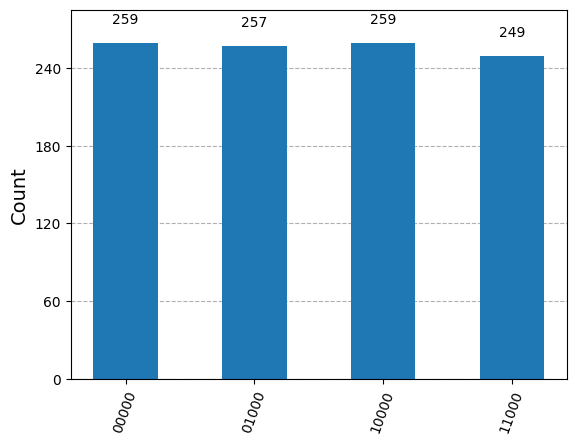

In [248]:
backend = Aer()
t_qc = transpile(qc, backend)
counts = backend.run(t_qc).result().get_counts()
print(f"Count of shots: {sum(counts.values())}")
plot_histogram(counts)

In [217]:
rows, measured_phases = [], []
for output in counts:
    decimal = int(output, 2)  # Convert (base 2) string to decimal
    phase = decimal/(2**qubits_count)  # Find corresponding eigenvalue
    measured_phases.append(phase)
    # Add these values to the rows in our table:
    rows.append([f"{output}(bin) = {decimal:>3}(dec)",
                 f"{decimal}/{2**qubits_count} = {phase:.2f}"])
# Print the rows in a table
headers=["Register Output", "Phase"]
df = pd.DataFrame(rows, columns=headers)
print(df)

         Register Output         Phase
0  01000(bin) =   8(dec)   8/32 = 0.25
1  10000(bin) =  16(dec)  16/32 = 0.50
2  00000(bin) =   0(dec)   0/32 = 0.00
3  11000(bin) =  24(dec)  24/32 = 0.75


In [218]:
rows = []
for phase in measured_phases:
    frac = Fraction(phase).limit_denominator(15)
    rows.append([phase,
                 f"{frac.numerator}/{frac.denominator}",
                 frac.denominator])
# Print as a table
headers=["Phase", "Fraction", "Guess for r"]
df = pd.DataFrame(rows, columns=headers)
print(df)

   Phase Fraction  Guess for r
0   0.25      1/4            4
1   0.50      1/2            2
2   0.00      0/1            1
3   0.75      3/4            4


In [219]:
def a2jmodN(a, j, N):
    """Compute a^{2^j} (mod N) by repeated squaring"""
    for _ in range(j):
        a = np.mod(a**2, N)
    return a

In [220]:
N = 15

np.random.seed(1) # This is to make sure we get reproduceable results
a = randint(2, 15)
print(a)

def qpe_amod15(a):
    """Performs quantum phase estimation on the operation a*r mod 15.
    Args:
        a (int): This is 'a' in a*r mod 15
    Returns:
        float: Estimate of the phase
    """
    qubits_count = 8
    qc = QuantumCircuit(4+qubits_count, qubits_count)
    for q in range(qubits_count):
        qc.h(q)     # Initialize counting qubits in state |+>
    qc.x(qubits_count) # And auxiliary register in state |1>
    for q in range(qubits_count): # Do controlled-U operations
        qc.append(c_amod15(a, 2**q),
                 [q] + [i+qubits_count for i in range(4)])
    qc.append(qft_dagger(qubits_count), range(qubits_count)) # Do inverse-QFT
    qc.measure(range(qubits_count), range(qubits_count))
    # Simulate Results
    backend = Aer()
    # `memory=True` tells the backend to save each measurement in a list
    job = backend.run(transpile(qc, backend), shots=1, memory=True)
    readings = job.result().get_memory()
    print("Register Reading: " + readings[0])
    phase = int(readings[0],2)/(2**qubits_count)
    print(f"Corresponding Phase: {phase}")
    return phase


7


In [221]:
phase = qpe_amod15(a) # Phase = s/r
Fraction(phase).limit_denominator(15)

Register Reading: 01000000
Corresponding Phase: 0.25


Fraction(1, 4)

In [222]:
frac = Fraction(phase).limit_denominator(15)
s, r = frac.numerator, frac.denominator
print(r)

4


In [223]:
guesses = [gcd(a**(r//2)-1, N), gcd(a**(r//2)+1, N)]
print(guesses)

[3, 5]


In [240]:
a = 7
FACTOR_FOUND = False
ATTEMPT = 0
while not FACTOR_FOUND:
    ATTEMPT += 1
    print(f"\nATTEMPT {ATTEMPT}:")
    phase = qpe_amod15(a) # Phase = s/r
    frac = Fraction(phase).limit_denominator(N)
    r = frac.denominator
    print(f"Result: r = {r}")
    if phase != 0:
        # Guesses for factors are gcd(x^{r/2} ±1 , 15)
        guesses = [gcd(a**(r//2)-1, N), gcd(a**(r//2)+1, N)]
        print(f"Guessed Factors: {guesses[0]} and {guesses[1]}")
        for guess in guesses:
            if guess not in [1,N] and (N % guess) == 0:
                # Guess is a factor!
                print(f"*** Non-trivial factor found: {guess} ***")
                FACTOR_FOUND = True
assert (3 in guesses) or (5 in guesses)


ATTEMPT 1:
Register Reading: 01000000
Corresponding Phase: 0.25
Result: r = 4
Guessed Factors: 3 and 5
*** Non-trivial factor found: 3 ***
*** Non-trivial factor found: 5 ***
